In [129]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [130]:
# usando as unidades de medida do SI
C = 100 * 10**-12
G_L, E_L = 10 * 10**-9, -70 * 10**-3
G_Na, E_Na = 3.6 * 10**-6, 55 * 10**-3
G_K, E_K = 1.6 * 10**-6, -90 * 10**-3
G_T, E_Ca = 0.22 * 10**-6, 120 * 10**-3


# valores iniciais
v0, h0, n0, h_t0 = -0.070, 0.89619, -0.06208, 1/(1+np.exp(3))

In [131]:
# variaveis de gating
def alpham(V):
    if V == (-0.035):
        return 10**3 / np.exp(-100*(V+0.035))
    else:
        return (10**5 * (V+0.035)) / (1 - np.exp(-100*(V+0.035)))
def alphan(V):
    if V == (-0.034):
        return (5 * 10**2) / np.exp(-100*(V+0.034))
    else:
        return (5 * 10**4 * (V+0.034)) / (1 - np.exp(-100*(V+0.034)))

def alphah(V): return 350*np.exp(-50*(V+0.058))

def betam(V): return 4000*np.exp(-(V+0.06)/0.018)
def betan(V): return 625*np.exp(-12.5*(V+0.044))
def betah(V): return 5000 / (1 + np.exp(-100*(V+0.028)))

def m_i(V): return alpham(V) / (alpham(V) + betam(V))
def m_ti(V): return 1 / (1+np.exp(-(V+0.052) / 0.0074))
def h_ti(V): return 1 / (1+np.exp(500*(V+0.076)))

def t_ht(V):
    if V>=(-0.080):
        return 0.028 + 0.001*np.exp(-(V+0.022) / 0.0105)
    else:
        return 0.001*np.exp(15*(V+0.467))

In [132]:
t = np.arange(0, 0.750, 0.00001)    # valores de tempo
valor_spike = 0.02 # valor em mV em que ocorre potencial de acao

# vetores para armazenar os resultados do loop
intervalosDisparos = []
temposDisparos = []
totalDisparos = []
menoresIntervalos = []
correntes_degrau = []
correntes_base = []

In [133]:
for m in range(11):
    for k in range(11):
        # corrente injetada
        J_base = (-200 + m*40) * 10**-12
        J_degrau = (k*10) * 10**-12
        J_soma = J_base + J_degrau
        ti_base = 0
        tf_base = 0.250
        ti_degrau = 0.250
        tf_degrau = 0.500
        
        def J_inj(t):
            return J_base*(t>ti_base)-J_base*(t>tf_base)+J_soma*(t>ti_degrau)-J_soma*(t>tf_degrau)+J_base*(t>0.500)


        # equacoes do modelo
        def dALLdt(X,t):
            V, h, n, h_t = X
            dVdt = (J_inj(t) - G_L*(V-E_L) - G_Na * m_i(V)**3 * h*(V-E_Na) - G_K * n**4 * (V-E_K) - G_T * m_ti(V)**2 * h_t*(V-E_Ca)) / C
            dhdt = alphah(V)*(1-h) - betah(V) * h
            dndt = alphan(V)*(1-n) - betan(V) * n
            dh_tdt = (h_ti(V) - h_t) / t_ht(V)

            return dVdt, dhdt, dndt, dh_tdt

        # solucao das equacoes
        X = odeint(dALLdt, [v0, h0, n0, h_t0], t)
        V = X[:,0] * 1000
        h = X[:,1]
        n = X[:,2]
        h_t = X[:,3]

       
        # loop para calcular o numero de disparos
        disparos = 0
        for i in range(len(V)-1):
            if V[i]<valor_spike and V[i+1]>valor_spike:
                temposDisparos.append(t[i])
                disparos += 1
        totalDisparos.append(disparos)
        
        # intervalos entre disparos em milissegundos
        for i in range(len(temposDisparos)-1):
            intervalo = temposDisparos[i+1] - temposDisparos[i]
            intervalosDisparos.append(intervalo)
            
        if len(intervalosDisparos) == 0:
            menor = 0
        else:
            menor = min(intervalosDisparos) * 1000
            
        menoresIntervalos.append(menor)
        
        # resetar os vetores
        intervalosDisparos.clear()
        temposDisparos.clear()
        
        # vetores com os valores de corrente
        correntes_degrau.append(J_degrau * 10**12)
        correntes_base.append(J_base * 10**12)


Text(0, 0.5, 'Correntes de Degrau (pA/cm2)')

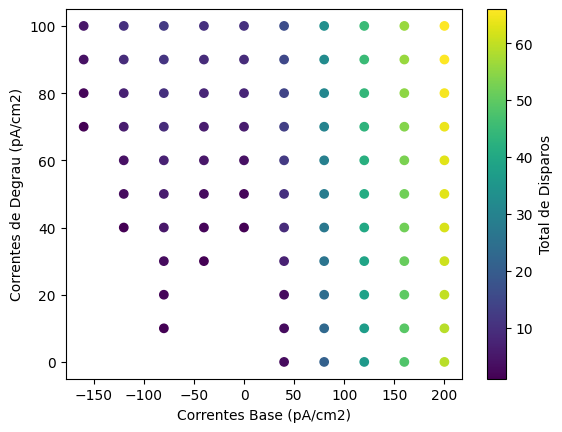

In [139]:
# Filtrar os dados para remover valores iguais a zero
correntes_base_filtered = []
correntes_degrau_filtered = []
totalDisparos_filtered = []

for i in range(len(totalDisparos)):
    if totalDisparos[i] != 0:
        correntes_base_filtered.append(correntes_base[i])
        correntes_degrau_filtered.append(correntes_degrau[i])
        totalDisparos_filtered.append(totalDisparos[i])

# Criar o gráfico de dispersão
plt.scatter(correntes_base_filtered, correntes_degrau_filtered, c=totalDisparos_filtered, cmap='viridis')

# Adicionar uma barra de cores
cbar = plt.colorbar()
cbar.set_label('Total de Disparos')

# Definir os rótulos dos eixos
plt.xlabel('Correntes Base (pA/cm2)')
plt.ylabel('Correntes de Degrau (pA/cm2)')


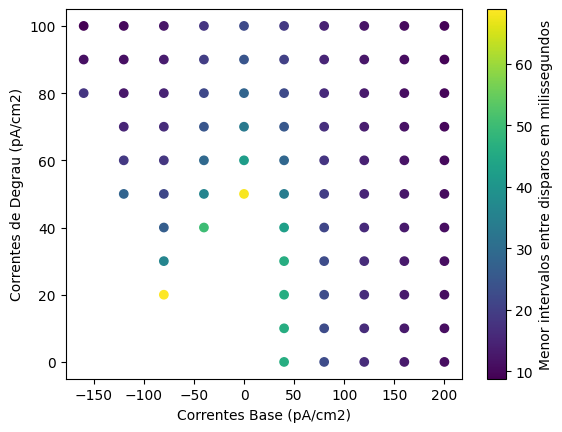

In [138]:
# Filtrar os dados para remover valores iguais a zero
correntes_base_filtered = []
correntes_degrau_filtered = []
menoresIntervalos_filtered = []

for i in range(len(menoresIntervalos)):
    if menoresIntervalos[i] != 0:
        correntes_base_filtered.append(correntes_base[i])
        correntes_degrau_filtered.append(correntes_degrau[i])
        menoresIntervalos_filtered.append(menoresIntervalos[i])

# Criar o gráfico de dispersão
plt.scatter(correntes_base_filtered, correntes_degrau_filtered, c=menoresIntervalos_filtered, cmap='viridis')

# Adicionar uma barra de cores
cbar = plt.colorbar()
cbar.set_label('Menor intervalos entre disparos em milissegundos')

# Definir os rótulos dos eixos
plt.xlabel('Correntes Base (pA/cm2)')
plt.ylabel('Correntes de Degrau (pA/cm2)')

# Exibir o gráfico
plt.show()